In [1]:
# import sys
# !{sys.executable} -m pip install nltk

In [2]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import re

import sklearn
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# scipy sparse matrix
import scipy
from scipy.sparse import hstack

import matplotlib.pyplot as plt

from string import digits

import os

## *SKIP* Data Preprocessing & Data Cleaning

We use the full unprocessed URL here

In [3]:
df = pd.read_csv('../../URL_Classification.csv', header=None)
df.columns = ["index", "url", "label"]

num_samples = len(df)
df = df[0:num_samples]

In [4]:
df.head(15)

,index,url,label
0,1,http://www.liquidgeneration.com/,Adult
1,2,http://www.onlineanime.org/,Adult
2,3,http://www.ceres.dti.ne.jp/~nekoi/senno/senfir...,Adult
3,4,http://www.galeon.com/kmh/,Adult
4,5,http://www.fanworkrecs.com/,Adult
5,6,http://www.animehouse.com/,Adult
6,7,http://www2.117.ne.jp/~mb1996ax/enadc.html,Adult
7,8,http://archive.rhps.org/fritters/yui/index.html,Adult
8,9,http://www.freecartoonsex.com/,Adult
9,10,http://www.cutepet.org/,Adult


## Labeling

In [5]:
unique_labels = list(set(df['label']))
unique_labels.sort()

label2idx = {unique_labels[k] : k for k in range(len(unique_labels))}
idx2label = {i: k for k, i in label2idx.items()}

In [6]:
label2idx

{'Adult': 0,
 'Arts': 1,
 'Business': 2,
 'Computers': 3,
 'Games': 4,
 'Health': 5,
 'Home': 6,
 'Kids': 7,
 'News': 8,
 'Recreation': 9,
 'Reference': 10,
 'Science': 11,
 'Shopping': 12,
 'Society': 13,
 'Sports': 14}

In [7]:
df['label'] = df['label'].map(label2idx)

## Bag of Words

In [8]:
bow_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(4, 4))

In [9]:
X = bow_vectorizer.fit_transform(df['url'].apply(lambda x: np.str_(x)))
y = df['label'].values

# data is still sorted
X, y = shuffle(X, y, random_state=67)

X.shape, y.shape

Training URL vectorizer...


((1562978, 683266), (1562978,))

## Use SGDClassifier as SVM with optimized alpha

In [10]:
clf = sklearn.linear_model.SGDClassifier(loss='hinge',
                                         class_weight='balanced',
                                         alpha=1.3945578080387041e-06,
                                         max_iter=1000,
                                         verbose=0,
                                         n_jobs=-1,
                                         n_iter_no_change=60,
                                         average=32)

### Split train/test set to evaluate result

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123456)

In [12]:
clf.fit(X_train, y_train)

SGDClassifier(alpha=1.3945578080387041e-06, average=32, class_weight='balanced',
              n_iter_no_change=60, n_jobs=-1)

In [13]:
print(classification_report(y_train, clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92     23761
           1       0.85      0.80      0.82    170083
           2       0.74      0.76      0.75    161094
           3       0.78      0.79      0.79     79213
           4       0.86      0.90      0.88     37665
           5       0.81      0.87      0.84     40161
           6       0.86      0.91      0.89     19008
           7       0.80      0.79      0.80     30965
           8       0.63      0.93      0.75      5956
           9       0.78      0.79      0.78     71261
          10       0.78      0.86      0.82     39055
          11       0.86      0.79      0.83     73809
          12       0.65      0.71      0.68     63951
          13       0.85      0.79      0.82    163512
          14       0.86      0.89      0.87     67701

    accuracy                           0.80   1047195
   macro avg       0.80      0.84      0.82   1047195
weighted avg       0.81   

In [14]:
y_pred = clf.predict(X_test)

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.69      0.68     11564
           1       0.65      0.62      0.64     83757
           2       0.57      0.60      0.59     79083
           3       0.54      0.56      0.55     38749
           4       0.62      0.60      0.61     18812
           5       0.57      0.59      0.58     19936
           6       0.63      0.60      0.61      9261
           7       0.44      0.40      0.42     15217
           8       0.34      0.43      0.38      3033
           9       0.51      0.52      0.51     35325
          10       0.57      0.61      0.59     19192
          11       0.62      0.57      0.60     36477
          12       0.41      0.45      0.43     31319
          13       0.66      0.62      0.64     80431
          14       0.69      0.71      0.70     33627

    accuracy                           0.59    515783
   macro avg       0.57      0.57      0.57    515783
weighted avg       0.59   

normalize true / rows


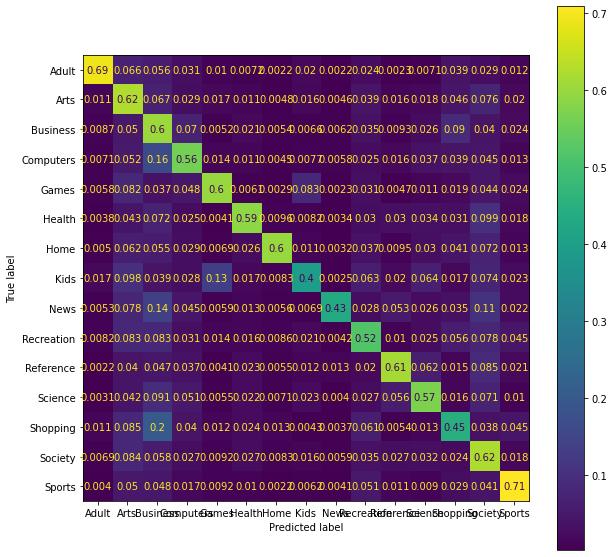

normalize pred / cols


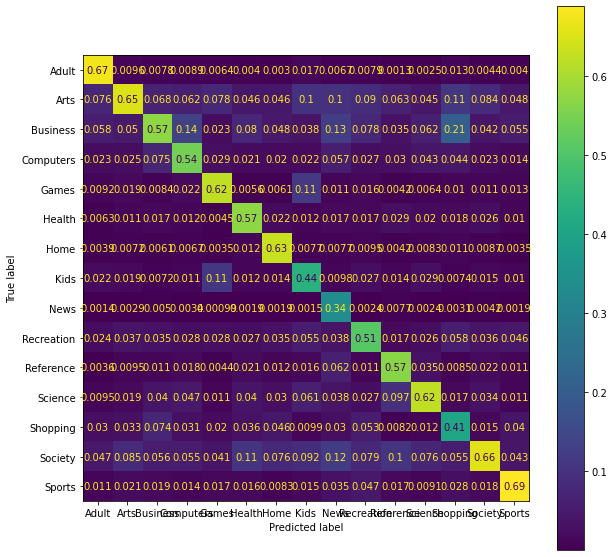

normalize all / cols + rows


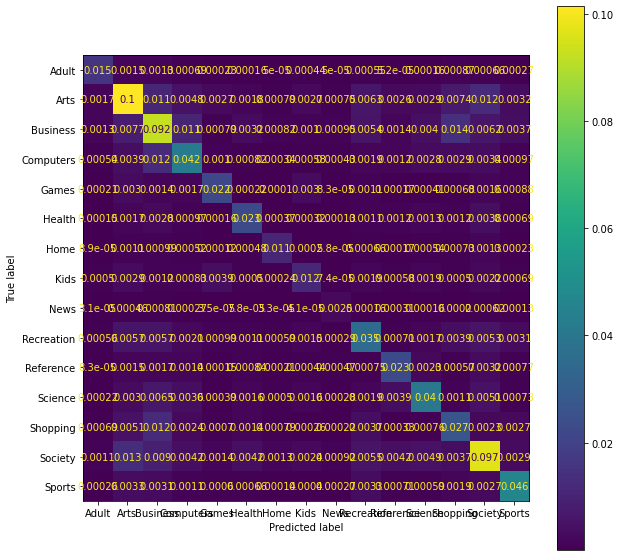

do not normalize


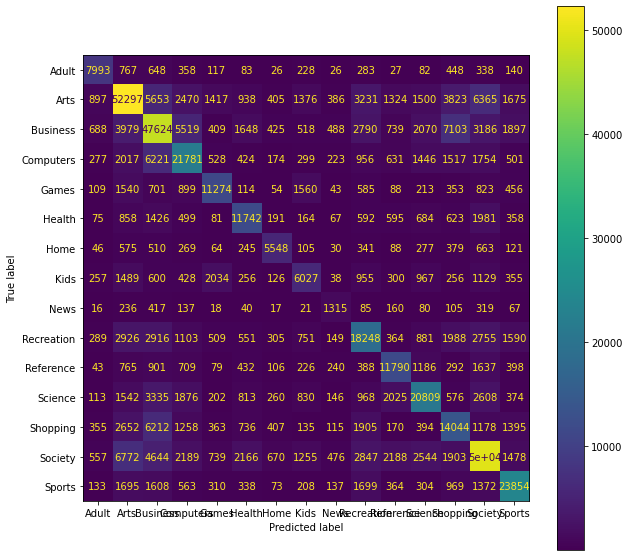

In [16]:
cm_true = confusion_matrix(y_test, y_pred, normalize='true', labels=[k for k in idx2label]) 
cm_pred = confusion_matrix(y_test, y_pred, normalize='pred', labels=[k for k in idx2label])
cm_all = confusion_matrix(y_test, y_pred, normalize='all', labels=[k for k in idx2label])
cm_none = confusion_matrix(y_test, y_pred, labels=[k for k in idx2label])


disp_true = ConfusionMatrixDisplay(confusion_matrix=cm_true, display_labels=unique_labels)
disp_pred = ConfusionMatrixDisplay(confusion_matrix=cm_pred, display_labels=unique_labels)
disp_all = ConfusionMatrixDisplay(confusion_matrix=cm_all, display_labels=unique_labels)
disp_none = ConfusionMatrixDisplay(confusion_matrix=cm_none, display_labels=unique_labels)

fig, ax = plt.subplots(figsize=(10, 10))
print('normalize true / rows')
disp_true.plot(include_values=True, ax=ax)
plt.show()

fig, bx = plt.subplots(figsize=(10, 10))
print('normalize pred / cols')
disp_pred.plot(include_values=True, ax=bx)
plt.show()

fig, cx = plt.subplots(figsize=(10, 10))
print('normalize all / cols + rows')
disp_all.plot(include_values=True, ax=cx)
plt.show()

fig, dx = plt.subplots(figsize=(10, 10))
print('do not normalize')
disp_none.plot(include_values=True, ax=dx)
plt.show()

In [ ]:
cvs = cross_val_score(clf, X, y, cv=3, scoring='f1_macro')
print(f'Mean {np.mean(cvs):.5f} \tVar {np.var(cvs):.5f}')
print(cvs)